# Section 10
### The Travelling Salesman Problem for american capitals
The code developed for exercise 09, improved with multiprocessing support, will be used to find the shortest path connecting the 50 american capitals starting from a fixed one (Montgomery, Alabama). Parallelism is implemented launching a number of processes each performing a genetic evolution of the same number of individuals; every given number of iterations the best individuals from each of such "continents" are gathered and distributed to all processes. It is not the globally best indivduals that are gathered, but a fixed number from each continent.

The performance of different crossover algorithms and hyperparameters will be compared, in particular:
- "ex", "exmod", "fusion" and "dummy" algorithms will be used;
- different "fusion_p" values will be used;
- different number of continents (hence processes) will be used.

In [1]:
import os
# Importing project specific variables and utilities,
# like the executable's path
from ex10.data import *
from ex10.compute import *
from ex10.plot import *
from global_utils import *

from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 150})

SECTION = "10"

# Whether to use cached data. The computation may take some time.
USE_CACHED = True

# The different values of n_continents that will be used
CONTINENTS = list(range(1, 8, 2))
# The different crossover algorithms that will be used
ALGOS = [Algo.EXERCISE, Algo.EXERCISEMOD, Algo.DUMMY, Algo.FUSION]

# Building a configuration table with the different hyperparameters
configs = {algo: {"mut_rate": 0.05, "fusion_p": None,
                  "n_continents": CONTINENTS} for algo in ALGOS}
# Declaring different "fusion_p". The values are concentrated in the range [0, 0.15] as it is found to return the best results
configs[Algo.FUSION]["fusion_p"] = np.concatenate([np.linspace(
    0.1, 0.9, 5, endpoint=True), np.linspace(0.0, 0.15, 7, endpoint=True)])
# "dummy"'s mutation rate should be higher than the other algorithms
configs[Algo.DUMMY]["mut_rate"] = 0.3
# Transforming to a pandas DataFrame where each row is a different set of hyperparameters that can be used for a single run
configs = (pd.DataFrame.from_dict(configs)
                       .transpose().reset_index(drop=False, names="algo")
                       # Distributing the "fusion_p"s to different rows
                       .explode("fusion_p", ignore_index=True)
                       # Distributing the "n_continents"s to different rows
                       .explode("n_continents", ignore_index=True)
                       .astype({"algo": "category", "mut_rate": "float", "fusion_p": "float", "n_continents": "int"}))
configs


,algo,mut_rate,fusion_p,n_continents
0,Algo.EXERCISE,0.05,NaN,1
1,Algo.EXERCISE,0.05,NaN,3
2,Algo.EXERCISE,0.05,NaN,5
3,Algo.EXERCISE,0.05,NaN,7
4,Algo.EXERCISEMOD,0.05,NaN,1
5,Algo.EXERCISEMOD,0.05,NaN,3
6,Algo.EXERCISEMOD,0.05,NaN,5
7,Algo.EXERCISEMOD,0.05,NaN,7
8,Algo.DUMMY,0.30,NaN,1
9,Algo.DUMMY,0.30,NaN,3


In [2]:
# Translating the .dat file in a .csv file
import re
with open(ROOT / "data" / "paths" / "American_capitals.dat", "rt") as f:
    s = f.readlines()
with open(ROOT / "data" / "paths" / "American_capitals.csv", "wt") as f:
    f.writelines([re.sub('\s{2,}', ',', line.strip())+'\n' for line in s])

In [4]:
capitals = pd.read_csv(ROOT / "data" / "paths" / "American_capitals.csv", dtype={"longitude": "float", "latitude": "float", "#name": "string", "description": "string"}).rename(columns={"#name": "name"})
# Storing the capitals list in a format which the executable understands: a csv with only two columns of coordinates
os.makedirs(CAPITALS_PATH.parent, exist_ok=True)
capitals[["longitude", "latitude"]].to_csv(
    CAPITALS_PATH, header=False, index=False)


# Population size used by each process (circa)
POP_SIZE_CA = 50_000
# Iterating over the configuration table's rows. This will take quite a while
for _, config in tqdm(configs.iterrows()):
    # Adjusting the population size so that it is divisible by the number of processes. This is needed by the parallel algorithm
    pop_size = POP_SIZE_CA - (POP_SIZE_CA % config["n_continents"])
    # Running the genetic process
    run_gp(CAPITALS_PATH, migration_length=500, n_migrations=5, pop_size=pop_size, p_line=0, use_cached=USE_CACHED, **config)


cross_p: exmod_0.000000[================================================================================] :48s<00m:00s] best fitness: 0.004478
cross_p: exmod_0.000000[================================================================================] :00s<00m:00s] best fitness: 0.003447
cross_p: exmod_0.000000[================================================================================] :10s<00m:00s] best fitness: 0.003523


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24130/1/vader_segment.MBP-di-Davide.501.37070001.3
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: dummy_0.000000[================================================================================] :17s<00m:00s] best fitness: 0.003095
cross_p: dummy_0.000000[================================================================================] :20s<00m:00s] best fitness: 0.003364
cross_p: dummy_0.000000[================================================================================] :27s<00m:00s] best fitness: 0.003648
cross_p: dummy_0.000000[================================================================================] :33s<00m:00s] best fitness: 0.003615


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24183/1/vader_segment.MBP-di-Davide.501.37320001.5
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24183] [[14130,0],0] ORTE_ERROR_LOG: Data unpack would read past end of buffer in file util/show_help.c at line 501
[MBP-di-Davide:24183] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24183] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.100000[================================================================================] :44s<00m:00s] best fitness: 0.004078
cross_p: fusion_0.100000[================================================================================] :49s<00m:00s] best fitness: 0.004421
cross_p: fusion_0.100000[================================================================================] :01s<00m:00s] best fitness: 0.004395


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24229/1/vader_segment.MBP-di-Davide.501.37e00001.3
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24229] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24229] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.100000[================================================================================] :14s<00m:00s] best fitness: 0.004463


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24254/1/vader_segment.MBP-di-Davide.501.37fb0001.6
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24254] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24254] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.300000[================================================================================] :56s<00m:00s] best fitness: 0.002705
cross_p: fusion_0.300000[================================================================================] :01s<00m:00s] best fitness: 0.002797
cross_p: fusion_0.300000[================================================================================] :15s<00m:00s] best fitness: 0.002837


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24317/1/vader_segment.MBP-di-Davide.501.37b80001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: fusion_0.300000[================================================================================] :27s<00m:00s] best fitness: 0.003126


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24336/1/vader_segment.MBP-di-Davide.501.36550001.1
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24336] 2 more processes have sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24336] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.500000[================================================================================] :07s<00m:00s] best fitness: 0.002837
cross_p: fusion_0.500000[================================================================================] :12s<00m:00s] best fitness: 0.003406
cross_p: fusion_0.500000[================================================================================] :28s<00m:00s] best fitness: 0.003028
cross_p: fusion_0.500000[================================================================================] :41s<00m:00s] best fitness: 0.003252


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24414/1/vader_segment.MBP-di-Davide.501.361b0001.2
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24414] 2 more processes have sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24414] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.700000[================================================================================] :16s<00m:00s] best fitness: 0.003275
cross_p: fusion_0.700000[================================================================================] :21s<00m:00s] best fitness: 0.003375
cross_p: fusion_0.700000[================================================================================] :39s<00m:00s] best fitness: 0.003313
cross_p: fusion_0.700000[================================================================================] :59s<00m:00s] best fitness: 0.003394


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24504/1/vader_segment.MBP-di-Davide.501.36fd0001.4
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24504] [[14077,0],0] ORTE_ERROR_LOG: Data unpack would read past end of buffer in file util/show_help.c at line 501
[MBP-di-Davide:24504] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24504] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.900000[================================================================================] :25s<00m:00s] best fitness: 0.003310
cross_p: fusion_0.900000[================================================================================] :29s<00m:00s] best fitness: 0.003421
cross_p: fusion_0.900000[================================================================================] :49s<00m:00s] best fitness: 0.003431


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24578/1/vader_segment.MBP-di-Davide.501.9470001.3
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: fusion_0.900000[================================================================================] :08s<00m:00s] best fitness: 0.003610


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24609/1/vader_segment.MBP-di-Davide.501.9640001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: fusion_0.000000[================================================================================] :39s<00m:00s] best fitness: 0.003300
cross_p: fusion_0.000000[================================================================================] :42s<00m:00s] best fitness: 0.004221
cross_p: fusion_0.000000[================================================================================] :56s<00m:00s] best fitness: 0.004319
cross_p: fusion_0.000000[================================================================================] :07s<00m:00s] best fitness: 0.004352


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24677/1/vader_segment.MBP-di-Davide.501.9200001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: fusion_0.025000[================================================================================] :40s<00m:00s] best fitness: 0.004154
cross_p: fusion_0.025000[================================================================================] :45s<00m:00s] best fitness: 0.003346
cross_p: fusion_0.025000[================================================================================] :59s<00m:00s] best fitness: 0.003728


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24727/1/vader_segment.MBP-di-Davide.501.9d20001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: fusion_0.025000[================================================================================] :08s<00m:00s] best fitness: 0.004429


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24743/1/vader_segment.MBP-di-Davide.501.9e20001.5
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24743] 3 more processes have sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24743] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.050000[================================================================================] :41s<00m:00s] best fitness: 0.004176
cross_p: fusion_0.050000[================================================================================] :46s<00m:00s] best fitness: 0.003629
cross_p: fusion_0.050000[================================================================================] :00s<00m:00s] best fitness: 0.004232


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24784/1/vader_segment.MBP-di-Davide.501.9950001.3
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: fusion_0.050000[================================================================================] :11s<00m:00s] best fitness: 0.004339


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24798/1/vader_segment.MBP-di-Davide.501.99b0001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24798] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24798] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.075000[================================================================================] :43s<00m:00s] best fitness: 0.004240
cross_p: fusion_0.075000[================================================================================] :47s<00m:00s] best fitness: 0.004441
cross_p: fusion_0.075000[================================================================================] :01s<00m:00s] best fitness: 0.004344
cross_p: fusion_0.075000[================================================================================] :17s<00m:00s] best fitness: 0.004434


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.24886/1/vader_segment.MBP-di-Davide.501.8730001.3
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:24886] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:24886] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.125000[================================================================================] :49s<00m:00s] best fitness: 0.002994
cross_p: fusion_0.125000[================================================================================] :51s<00m:00s] best fitness: 0.004202
cross_p: fusion_0.125000[================================================================================] :59s<00m:00s] best fitness: 0.003383
cross_p: fusion_0.125000[================================================================================] :12s<00m:00s] best fitness: 0.004397


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.25353/1/vader_segment.MBP-di-Davide.501.a4c0001.3
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


cross_p: fusion_0.150000[================================================================================] :47s<00m:00s] best fitness: 0.003584
cross_p: fusion_0.150000[================================================================================] :53s<00m:00s] best fitness: 0.002808
cross_p: fusion_0.150000[================================================================================] :02s<00m:00s] best fitness: 0.004112


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.25429/1/vader_segment.MBP-di-Davide.501.a100001.4
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[MBP-di-Davide:25429] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[MBP-di-Davide:25429] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


cross_p: fusion_0.150000[================================================================================] :17s<00m:00s] best fitness: 0.004294


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MBP-di-Davide
  System call: unlink(2) /var/folders/v8/rkcmmnk1069061z11pxj_qzr0000gn/T//ompi.MBP-di-Davide.501/pid.25476/1/vader_segment.MBP-di-Davide.501.ac10001.5
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


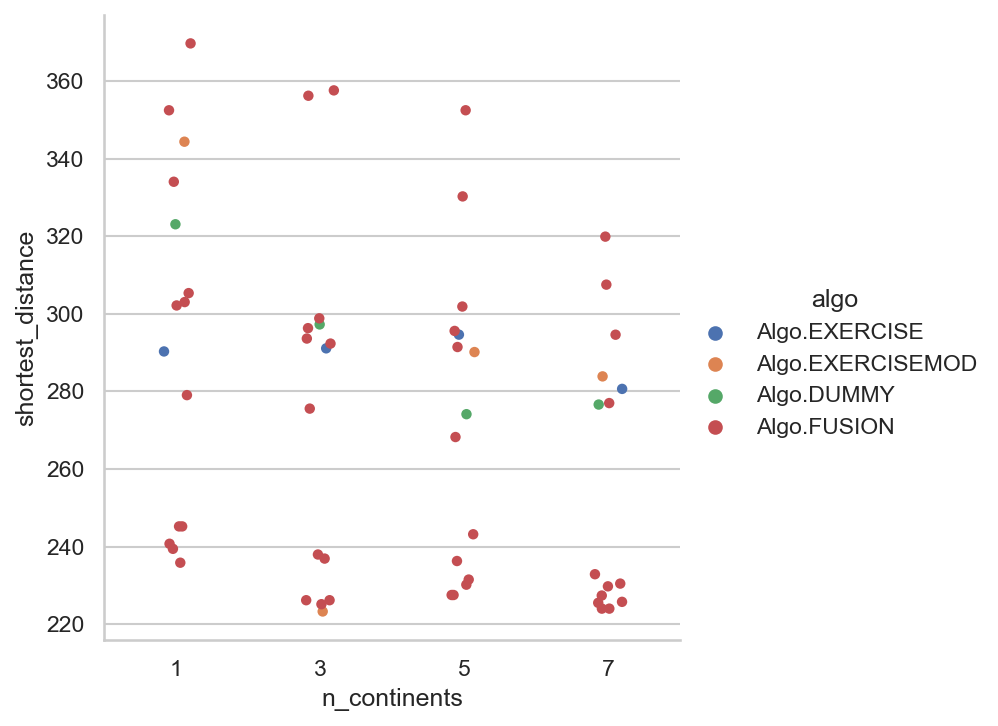

In [5]:
# Collecting the best results (shortest distance and best individual) from each configuration
bests = collect_best_results(configs)
# showing the relation between shortest distance and the number of continents with a scatter plot
_ = sns.catplot(bests, y="shortest_distance", x="n_continents", hue="algo", kind="strip")

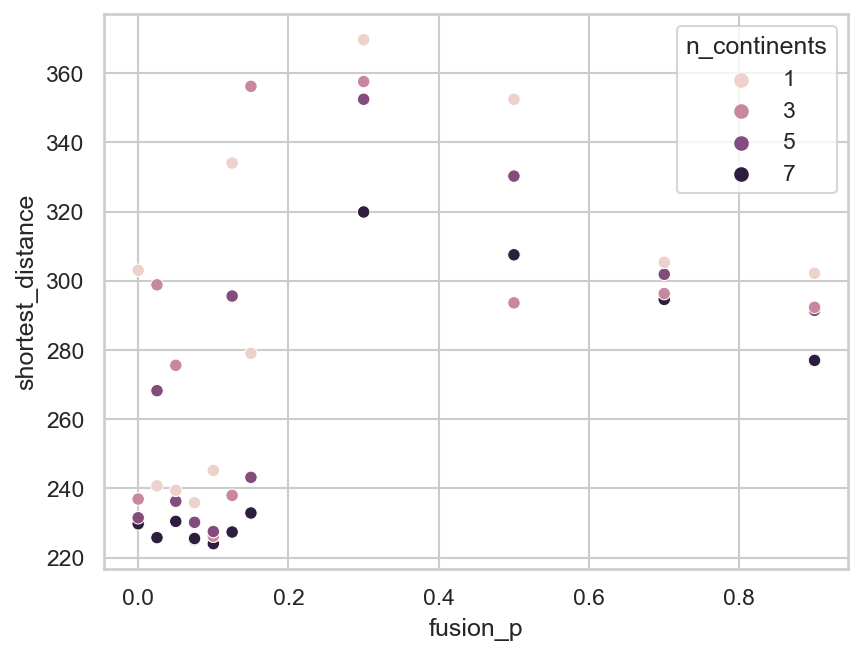

In [6]:
algo = Algo.FUSION
# Showing the relation between the shortest distance and the "fusion_p" parameter using a scatter plot
ax = sns.scatterplot(bests.query("algo == @algo"), x="fusion_p", y="shortest_distance", hue="n_continents")

From the plots above we see that a properly tuned "fusion" algorithm still provides the best results. The added entropy provided by a higher number of continents seems to influence the results in particular with "fusion" and "dummy".

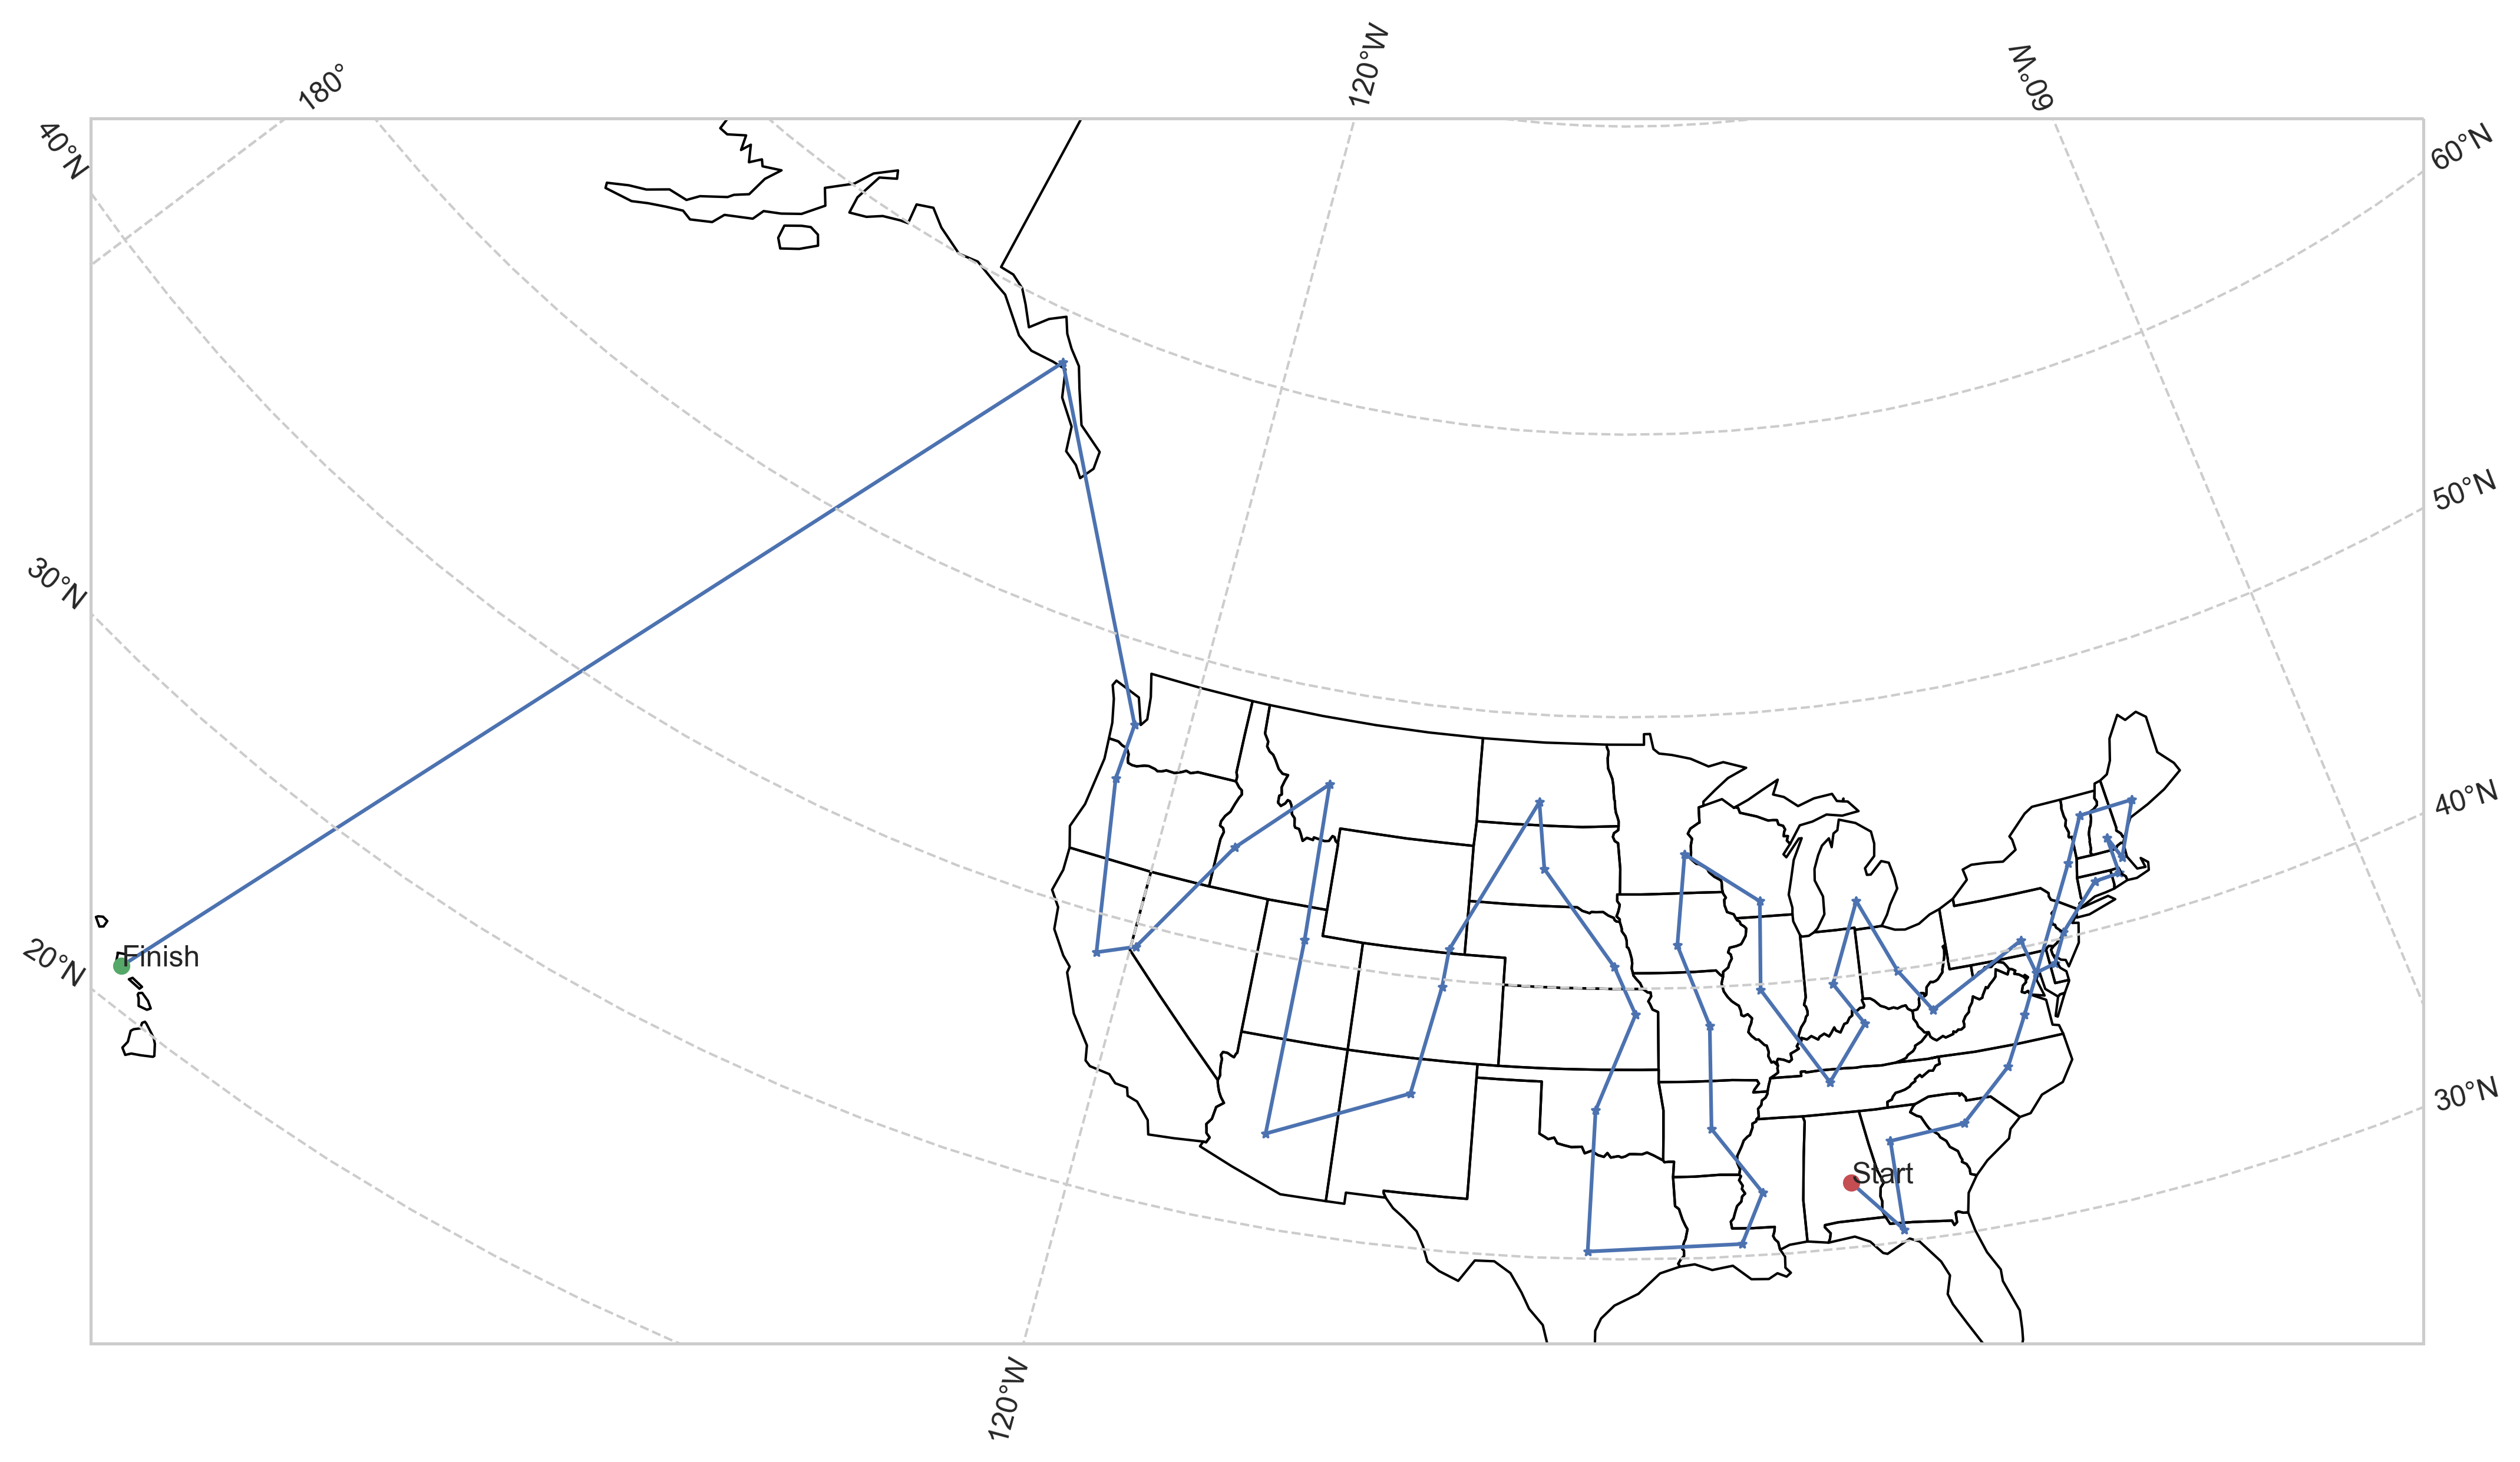

In [7]:
# Plotting the best result
best = bests.iloc[0]
_ = plot_on_map(best["algo"], best["n_continents"], capitals, best["fusion_p"])


The solution has still some margins of improvements, but it follows an evidently logical route.